In [16]:
%cd /proj/azizpour-group/users/x_amime/projects/an_explanation_model

from source.project_manager import load_experiment_metadata
from source.data_manager import imagenet_loader_from_metadata
from source.model_manager import init_resnet50_forward, forward_with_projection
import argparse
import jax
import tensorflow as tf
import jax.numpy as jnp
import os
from glob import glob
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from functools import partial
from PIL import Image

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/x_amime/envs/.conda/envs/xlab/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
x = np.linspace(0, 3, 100)
a = np.array([.10, .15, .2])
f = lambda x,a: x*x*np.exp(-8*np.pi*np.pi*a*a*x*x)
y = np.array([f(x, a_i) for a_i in a])

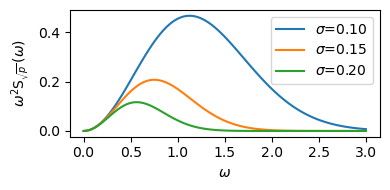

In [4]:
u=4
fig,ax = plt.subplots(1, 1, figsize=(u, u/2))
for i in range(len(a)):
    ax.plot(x, y[i], label=r'$\sigma$'+f'={a[i]:.2f}')
ax.legend()

ax.set_ylabel(r'$\omega^2\operatorname{S}_{\sqrt{p}}(\omega)$')
# ax.set_yticks([])
ax.set_xlabel(r'$\omega$')
plt.tight_layout()

plt.savefig('outputs/figures/bands.pdf')

In [3]:
save_metadata_dir = "outputs/metadata/7_2_convex_*/"
paths = os.path.join(save_metadata_dir, "merged_metadata.csv")
paths = glob(paths)
data = []
for path in paths:
    project_metadata = pd.read_csv(path)
    ids =(project_metadata.stream_name == "vanilla_grad_mask") & (project_metadata.stream_statistic == "meanx2")
    project_metadata = project_metadata[ids]
    data.append(project_metadata.copy())

project_metadata = pd.concat(data)

In [13]:
def compute_normalized_similarity(row):
    alpha = row["alpha_mask_value"]
    data_path = row["data_path"]
    if os.path.exists(data_path):
        data = np.load(data_path)
        return data.sum() * (alpha**(2.5))
    else:
        return -1


temp = project_metadata[["alpha_mask_value", "data_path"]]
temp = temp.apply(compute_normalized_similarity, axis=1)
temp = pd.concat([temp,project_metadata[["alpha_mask_value", "image_index"]]], axis=1)
temp.rename(columns={0: "similarity"}, inplace=True)
temp.to_csv("outputs/processed/KC_similarity.csv", index=False)

In [5]:
temp = pd.read_csv("outputs/processed/KC_similarity.csv")
temp = temp.drop(columns="image_index")

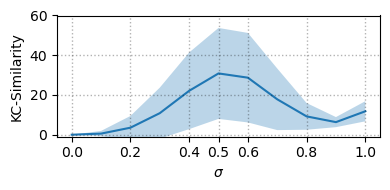

In [6]:
u=4
fig, ax = plt.subplots(1,1,figsize=(u, u/2))
# plot mean with error bands
means = temp.groupby("alpha_mask_value").mean()
stds = temp.groupby("alpha_mask_value").std()
ax.plot(means.index, means.similarity, label="mean")
ax.fill_between(
    means.index,
    means.similarity - stds.similarity,
    means.similarity + stds.similarity,
    alpha=0.3,
)
plt.xlabel(r"$\sigma$")
plt.ylabel(
    "KC-Similarity"
)
# draw lines
xticks = ax.get_xticks()
xticks = list(xticks) 
xticks.append(0.5)
ax.set_xticks(xticks)
for data in xticks:
    plt.axvline(data, linestyle=":", color="black", alpha=0.3, linewidth=1)
yticks = plt.yticks()[0]
for y in yticks:
    plt.axhline(y, linestyle=":", color="black", alpha=0.3, linewidth=1)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-1, 60)
# make figure square
plt.tight_layout()

plt.savefig("outputs/figures/band_similarity.pdf", bbox_inches="tight")

In [ ]:
from source.data_manager import minmax_normalize


norm_similarity_image = np.zeros((224, 224, 3))
def compute_normalized_similarity_image(row):
    global norm_similarity_image
    alpha = row["alpha_mask_value"]
    data_path = row["data_path"]
    if os.path.exists(data_path):
        data = np.load(data_path)
        norm_similarity_image = (data * (alpha**(2.5)))/temp.shape[0] + norm_similarity_image
        return 0
    else:
        return -1


temp = project_metadata[["alpha_mask_value", "data_path"]]
temp = temp[project_metadata.image_index == 0]
print(temp.shape)
temp.apply(compute_normalized_similarity_image, axis=1)

np.save("outputs/processed/norm_similarity_image.npy",norm_similarity_image)
plt.imshow(minmax_normalize(norm_similarity_image), cmap="hot")
# this shows that most of the images are object centered!

In [ ]:
n_rows = 1
n_cols = 3
scale = 2
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * scale, n_rows * scale / 2),
    sharey=True,
    sharex=True,
)
for i, ax in enumerate(axes):
    ax.set_xlabel("Perturbation Scale")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    # frame off
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_ylabel("Output")

axes[2].plot([1, 0], [0, 0.5], color="blue")
axes[2].plot([0, 0], [0, 0.5], color="blue")
axes[2].plot([1, 0], [0, 0], color="blue")

axes[2].plot([1, 0], [0.5, 1], color="red")
axes[2].plot([0, 0], [0.5, 1], color="red")
axes[2].plot([1, 1], [0, 0.5], color="red")

axes[2].text(0.5, 0.5, "noise", ha="center", va="center")
axes[2].text(0.25, 0.15, "signal", ha="center", va="center")

axes[2].fill_between(
    [0, 1], [0.5, 0], [1, 0.5], color="pink", alpha=0.2, edgecolor="red", hatch="|"
)
axes[2].fill_between(
    [0, 1], [0, 0], [0.5, 0], color="lightblue", alpha=0.2, edgecolor="blue", hatch="+"
)

axes[1].plot([1, 0], [0, 1], color="blue")
axes[1].plot([0, 0], [0, 1], color="blue")
axes[1].plot([1, 0], [0, 0], color="blue")

axes[1].plot([1, 0], [1, 1], color="red")
axes[1].plot([1, 1], [0, 1], color="red")

axes[1].text(0.75, 0.75, "noise", ha="center", va="center")
axes[1].text(0.25, 0.25, "signal", ha="center", va="center")

axes[1].fill_between(
    [0, 1], [1, 0], [1, 1], color="pink", alpha=0.2, edgecolor="red", hatch="|"
)
axes[1].fill_between(
    [0, 1], [0, 0], [1, 0], color="lightblue", alpha=0.2, edgecolor="blue", hatch="+"
)
198

axes[0].plot([1, 0], [0.5, 0.5], color="blue")
axes[0].plot([0, 0], [0, 0.5], color="blue")
axes[0].plot([1, 0], [0, 0], color="blue")
axes[0].plot([1, 1], [0, 0.5], color="blue")

axes[0].plot([0, 1], [0.5, 1], color="red")
axes[0].plot([1, 1], [0.5, 1], color="red")

axes[0].text(0.75, 0.65, "noise", ha="center", va="center")
axes[0].text(0.5, 0.25, "signal", ha="center", va="center")

axes[0].fill_between(
    [0, 1], [0.5, 0.5], [0.5, 1], color="pink", alpha=0.2, edgecolor="red", hatch="|"
)
axes[0].fill_between(
    [0, 1],
    [0, 0],
    [0.5, 0.5],
    facecolor="lightblue",
    alpha=0.2,
    edgecolor="blue",
    hatch="+",
)

plt.show()
fig.savefig("outputs/figures/combination_fns.pdf", bbox_inches="tight")

In [41]:
path = "outputs/metadata/7_3*/"
df = load_experiment_metadata(path,"merged_ig_metadata.csv")
df.set_index(["alpha_mask_value"], inplace=True)
df.sort_index(inplace=True)

In [42]:
df

,data_path,stream_name,stream_statistic,projection_type,projection_top_k,image_path,label,baseline_mask_type,ig_elementwise
alpha_mask_value,,,,,,,,,
ig_occlusion_u_x2_nan,/proj/azizpour-group/users/x_amime/projects/an...,vanilla_grad_mask,meanx2,prediction,1,/proj/azizpour-group/datasets/imagenet/val/n02...,196,static,False
ig_occlusion_u_x2_nan,/proj/azizpour-group/users/x_amime/projects/an...,vanilla_grad_mask,meanx2,prediction,1,/proj/azizpour-group/datasets/imagenet/val/n02...,148,static,False
ig_occlusion_u_x2_nan,/proj/azizpour-group/users/x_amime/projects/an...,vanilla_grad_mask,meanx2,prediction,1,/proj/azizpour-group/datasets/imagenet/val/n03...,666,static,False
ig_occlusion_u_x2_nan,/proj/azizpour-group/users/x_amime/projects/an...,vanilla_grad_mask,meanx2,prediction,1,/proj/azizpour-group/datasets/imagenet/val/n03...,624,static,False
ig_occlusion_u_x2_nan,/proj/azizpour-group/users/x_amime/projects/an...,vanilla_grad_mask,meanx2,prediction,1,/proj/azizpour-group/datasets/imagenet/val/n01...,46,static,False
ig_occlusion_u_x_nan,/proj/azizpour-group/users/x_amime/projects/an...,vanilla_grad_mask,meanx,prediction,1,/proj/azizpour-group/datasets/imagenet/val/n01...,46,static,False
ig_occlusion_u_x_nan,/proj/azizpour-group/users/x_amime/projects/an...,vanilla_grad_mask,meanx,prediction,1,/proj/azizpour-group/datasets/imagenet/val/n02...,148,static,False
ig_occlusion_u_x_nan,/proj/azizpour-group/users/x_amime/projects/an...,vanilla_grad_mask,meanx,prediction,1,/proj/azizpour-group/datasets/imagenet/val/n03...,666,static,False
ig_occlusion_u_x_nan,/proj/azizpour-group/users/x_amime/projects/an...,vanilla_grad_mask,meanx,prediction,1,/proj/azizpour-group/datasets/imagenet/val/n03...,624,static,False


In [69]:
import PIL
i=5
x = np.load(df.loc["ig_rise_u_x_0.1","data_path"][i])
x2 = np.load(df.loc["ig_rise_u_x2_0.1","data_path"][i])

img = PIL.Image.open(df.loc["ig_rise_u_x_0.1","image_path"][i])

x = x.sum(axis=-1)
x2 = x2.sum(axis=-1)

/tmp/ipykernel_3956110/2168569568.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = np.load(df.loc["ig_rise_u_x_0.1","data_path"][i])


IndexError: index 5 is out of bounds for axis 0 with size 5

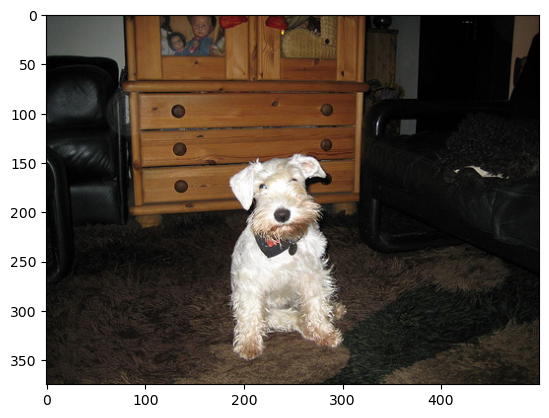

In [67]:
plt.imshow(img)

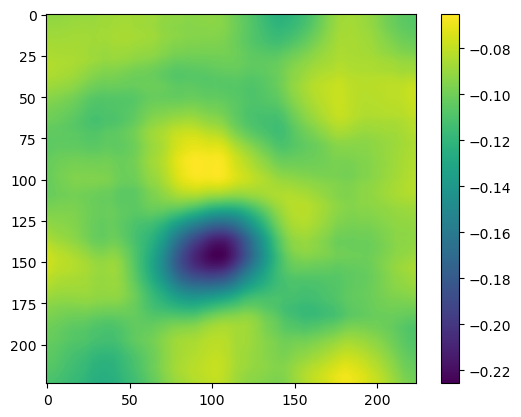

In [68]:
im = plt.imshow(x)
plt.colorbar(im)

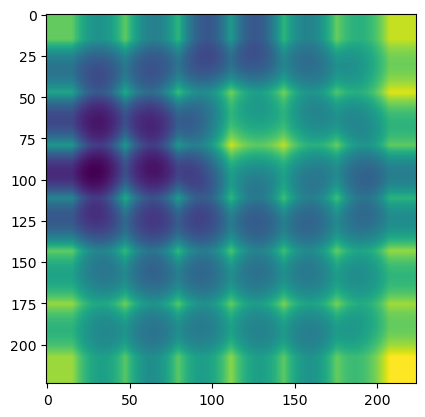

In [30]:
plt.imshow(x2)